In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import difflib
import string
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import Birch
from matplotlib.colors import ListedColormap
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_regression,r_regression,f_classif
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift

In [2]:
df1=pd.read_csv('Read_file_clustering.csv')
df=df1.copy()
df.drop(['Unnamed: 0','Contact_ID'],axis=1,inplace=True)

In [3]:
for col in df1.columns:
    if 'HH:mm:ss' in col:
      time_in_days=[] 
      for i in range(len(df1[col].unique())): 
        hours=df1[col].iloc[i].split(':')[0]
        days=np.round(int(hours)/24,0)
        time_in_days.append(days)
      df1[col].replace(df1[col].unique(),time_in_days,inplace=True) 

In [4]:
from sklearn import preprocessing        

columnsToEncode = list(df.select_dtypes(include=['category','object','bool']))

for col in columnsToEncode:
     le = preprocessing.LabelEncoder()   
     df[col]=le.fit_transform(df[col])
    
scaler = MinMaxScaler()
X=scaler.fit(df).transform(df)    

In [5]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
# If p-value < 0.05 -->Significant
# If p-value > 0.05 -->Not Significant
y=df['Customer']
# X=df.drop(['Record_ID','Latest_Source_Timestamp_y','Customer','Lifecycle_Stage_y'],axis=1)
X=df.drop(['Record_ID','Latest_Source_Timestamp_y','Original_Source_Type_y','Latest_Source_Timestamp_y','Latest_Source_Data_1_y','Latest_Source','Latest_Source_Drill-Down_1','Latest_Source_y','Customer','Lead_Source','Demo_Sat','Average_Pageviews','Record_ID_y','Currently_in_workflow','Number_of_Form_Submissions_y','SQL_',"Web_Technologies","Number_of_Open_Tickets_(Issues)","Time_from_SQL_to_SAL_(HH:mm:ss)","Time_MQL_to_SQL__(HH:mm:ss)",'Latest_Source_Drill-Down_1','Latest_Source',"Time_MQL_to_SAL_(HH:mm:ss)","Time_to_close_from_SQL_to_customer_(HH:mm:ss)","Time_to_SAL_from_create_(HH:mm:ss)",'Forecast_probability','Forecast_category','Company_ID','Monthly_recurring_revenue','Annual_contract_value'],axis=1)
X_train,X_test, Y_train, Y_test = train_test_split(X, y, test_size = .2, random_state = 10)

x_incl_cons = sm.add_constant(X_train)
model = sm.OLS(Y_train, x_incl_cons)  #ordinary least square
results = model.fit()  #regresssion results
# results.params
# results.pvalues
corr=pd.DataFrame({'coef': results.params , 'pvalue': round(results.pvalues,3)})
corr=corr.iloc[1:]
corr=corr[corr.pvalue<=0.05]
corr[['pvalue']]
best_features_p=corr.index
best_features_p

Index(['Broadcast_Clicks', 'Marketing_contact_status', 'Original_Source',
       'Contact_unworked', 'Number_of_event_completions',
       'Number_of_Unique_Forms_Submitted', 'LinkedIn_Clicks',
       'Original_Source_Drill-Down_1', 'Sends_Since_Last_Engagement',
       'HubSpot_Score', 'Contact_priority', 'Number_of_Sales_Activities_y',
       'Annual_recurring_revenue', 'Deal_Stage', 'Deal_probability',
       'Inbound/Outbound', 'Time_SQL_to_SAL_(HH:mm:ss)', 'Trial_Y/N',
       'Number_of_Pageviews_y', 'Likelihood_to_close_y',
       'Total_Number_of_Issues_(Open_&_Closed)', 'Is_Public',
       'Number_of_open_deals'],
      dtype='object')

In [6]:
# # from sklearn.ensemble import ExtraTreesClassifier

number_of_feature=25

# plt.figure(figsize=(15,10))
# model = ExtraTreesClassifier()
# model.fit(X,y)
# # print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# best_features_tree=[ind for ind in (pd.DataFrame(feat_importances.nlargest(number_of_feature))).index]
# feat_importances.nlargest(number_of_feature).plot(kind='barh')
# plt.show()

In [7]:
# apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(number_of_feature,'Score'))  #print 10 best features
bestfeatures_f=list(featureScores.nlargest(number_of_feature,'Score')['Specs'])

                                                Specs         Score
19                                   Deal_probability  38146.855893
24                                              SAL_y   2818.685404
14                       Number_of_Sales_Activities_y   2338.929707
5                    Number_of_Unique_Forms_Submitted   1142.671840
31             Total_Number_of_Issues_(Open_&_Closed)   1129.219635
12                                   Contact_priority    971.589135
13      Time_to_close_from_SAL_to_customer_(HH:mm:ss)    636.232488
23                                    Number_of_Demos    497.475929
16                           Annual_recurring_revenue    327.946277
27                               Number_of_Sessions_y    317.451401
22                         Time_SQL_to_SAL_(HH:mm:ss)    312.845562
21                                   Inbound/Outbound    308.487282
26                              Number_of_Pageviews_y    240.709240
20                                      Lead_Sou

In [8]:
features=[]
[features.append(fea) for fea in bestfeatures_f]
# for fea in best_features_tree:
#     if fea in features:
#         pass
#     else:
#         features.append(fea)
# for fea in best_features_p:
#     if fea in features:
#         pass
#     else:
#         features.append(fea)    
bestfeatures=features 
print(len(df[bestfeatures].columns))
bestfeatures

25


['Deal_probability',
 'SAL_y',
 'Number_of_Sales_Activities_y',
 'Number_of_Unique_Forms_Submitted',
 'Total_Number_of_Issues_(Open_&_Closed)',
 'Contact_priority',
 'Time_to_close_from_SAL_to_customer_(HH:mm:ss)',
 'Number_of_Demos',
 'Annual_recurring_revenue',
 'Number_of_Sessions_y',
 'Time_SQL_to_SAL_(HH:mm:ss)',
 'Inbound/Outbound',
 'Number_of_Pageviews_y',
 'Lead_Source_y',
 'Number_of_open_deals',
 'LinkedIn_Clicks',
 'Trial_Y/N',
 'Original_Source',
 'Broadcast_Clicks',
 'Likelihood_to_close_y',
 'CTA_Event_y',
 'Time_between_contact_creation_and_deal_creation_(HH:mm:ss)',
 'Original_Source_Drill-Down_1',
 'No_of_Employees_Band',
 'Marketing_contact_status']

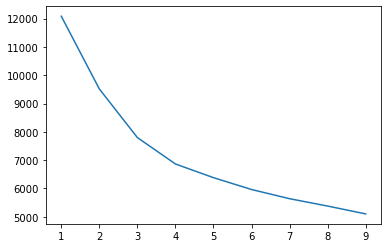

In [9]:
## Selecting two feature to perform clustering

cluster_Feature=MinMaxScaler()
cluster_Feature=scaler.fit(df[bestfeatures]).transform(df[bestfeatures])

# Determing the Number of clusters using elbow method

score_1 = []
range_values = range(1, 10)

for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(cluster_Feature)
    score_1.append(kmeans.inertia_)    
    
plt.plot(range_values,score_1)    

In [10]:
cluster=4
kmeans = KMeans(n_clusters=cluster, random_state=42).fit(cluster_Feature)
labels_kmeans = kmeans.labels_
score=silhouette_score(cluster_Feature, labels_kmeans, metric='euclidean')
print(score)


# aggloclust=AgglomerativeClustering(n_clusters=cluster).fit(cluster_Feature)
# AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
#             connectivity=None, linkage='ward', memory=None)
# agglo_labels = aggloclust.labels_
# score=silhouette_score(cluster_Feature, agglo_labels, metric='euclidean')
# print(score)

X=scaler.fit(cluster_Feature).transform(cluster_Feature)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2','principal component 3'])

0.27170088139527104


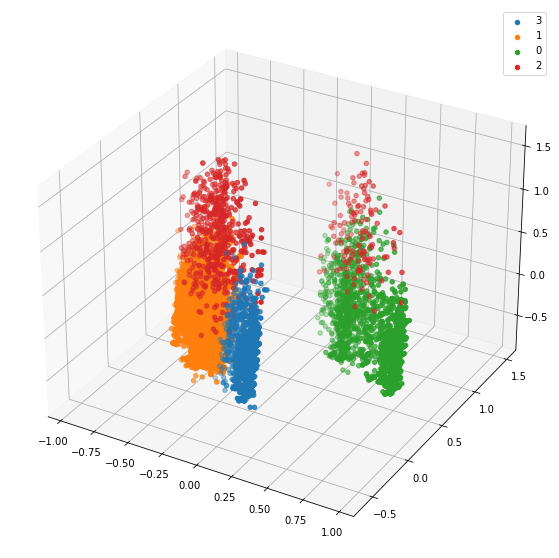

In [11]:
principalDf['Clusters']=labels_kmeans
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

for s in principalDf['Clusters'].unique():
    ax.scatter(principalDf['principal component 1'][principalDf.Clusters==s],principalDf['principal component 2'][principalDf.Clusters==s],principalDf['principal component 3'][principalDf.Clusters==s],label=s)
    
ax.legend()

In [12]:
figure = px.scatter_3d(principalDf,
                    color='Clusters',
                    x='principal component 1',
                    y='principal component 2',
                    z='principal component 3',            
                    category_orders = {"clusters": principalDf['Clusters'].unique()})
figure.update_layout()
figure.show()

In [13]:
# figure = px.scatter_3d(df1,
#                     color='Clusters',
#                     x='Annual_recurring_revenue',
#                     y='No_of_Employees_Band',
#                     z='Time_to_close_from_SAL_to_customer_(HH:mm:ss)',            
#                     category_orders = {"clusters": principalDf['Clusters'].unique()})
# figure.update_layout()
# figure.show()

In [14]:
# # Clustering with KMeans

# kmeans = KMeans(n_clusters=cluster, random_state=42).fit(cluster_Feature)
# labels_kmeans = kmeans.labels_
# centers = kmeans.cluster_centers_

# plt.figure(figsize=(8,5))
# sns.scatterplot(data=df1,x='Annual_recurring_revenue',y='No_of_Employees_Band',hue=labels_kmeans,palette='viridis')
# plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)
# plt.show()
# silhouette_score(cluster_Feature, labels_kmeans, metric='euclidean')

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Clusters', ylabel='count'>

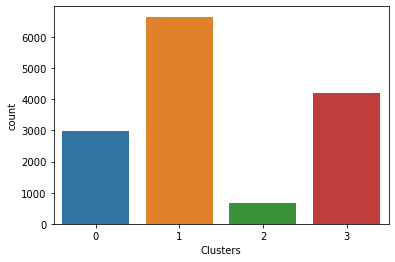

In [15]:
df1['Clusters']=labels_kmeans
sns.countplot(df1['Clusters'])

In [17]:
df1

Unnamed: 0  Broadcast_Clicks Marketing_contact_status  Original_Source  \
0               0               0.0        Marketing contact   Direct Traffic   
1               1               0.0        Marketing contact   Organic Search   
2               2               0.0    Non-marketing contact  Offline Sources   
3               3               0.0        Marketing contact   Organic Search   
4               4               0.0        Marketing contact   Organic Search   
...           ...               ...                      ...              ...   
14479       14479               0.0        Marketing contact  Offline Sources   
14480       14480               0.0        Marketing contact  Offline Sources   
14481       14481               0.0        Marketing contact  Offline Sources   
14482       14482               0.0        Marketing contact  Offline Sources   
14483       14483               0.0        Marketing contact   Direct Traffic   

       Currently_in_workflow  Contact_unworked  Number_of_event_completions  \
0                        0.0               0.0                          0.0   
1                        1.0               1.0                          0.0   
2                        0.0               1.0                          0.0   
3                        0.0               1.0                          0.0   
4                        0.0               0.0                          1.0   
...                      ...               ...                          ...   
14479                    1.0               1.0                          0.0   
14480                    0.0               1.0                          0.0   
14481                    0.0               1.0                          0.0   
14482                    0.0               1.0                          0.0   
14483                    0.0               0.0                          0.0   

       Average_Pageviews  Number_of_Unique_Forms_Submitted  LinkedIn_Clicks  \
0                    2.0                               2.0              0.0   
1                    2.0                               2.0              0.0   
2                    2.0                               1.0              0.0   
3                    3.0                               2.0              0.0   
4                    3.0                               1.0              0.0   
...                  ...                               ...              ...   
14479                1.0                               1.0              0.0   
14480                0.0                               1.0              0.0   
14481                1.0                               2.0              0.0   
14482                4.0                               2.0              0.0   
14483                1.0                               4.0              0.0   

       ...                             Latest_Source_Data_1_y  \
0      ...          www.staffcircle.com/start-your-free-trial   
1      ...          www.staffcircle.com/start-your-free-trial   
2      ...          www.staffcircle.com/start-your-free-trial   
3      ...  www.staffcircle.com/resources/type/ebook/the-u...   
4      ...                             Unknown keywords (SSL)   
...    ...                                                ...   
14479  ...                                             IMPORT   
14480  ...                                           hs_email   
14481  ...                                           hs_email   
14482  ...                                             IMPORT   
14483  ...              q2 - 2022 performance august campaign   

       Likelihood_to_close_y Country/Region_y  \
0                      13.66               UK   
1                      13.66               UK   
2                      13.66               UK   
3                       8.67             NONE   
4                       8.04          NIGERIA   
...                      ...              ...   
14479       

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Trial_Y/N', ylabel='count'>

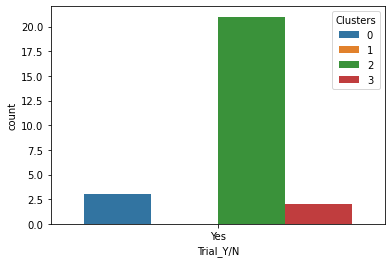

In [18]:
sns.countplot(df1[df1["Trial_Y/N"]=='Yes']['Trial_Y/N'],hue=df1['Clusters'])

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Demo_Sat', ylabel='count'>

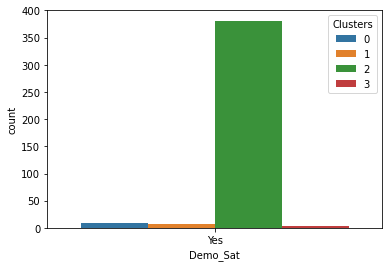

In [19]:
sns.countplot(df1[df1["Demo_Sat"]=='Yes'].Demo_Sat,hue=df1['Clusters'])

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='SQL_', ylabel='count'>

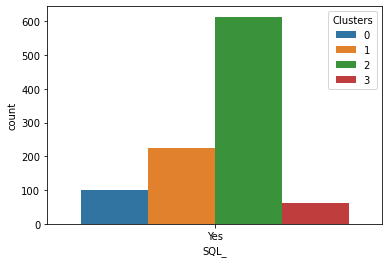

In [20]:
sns.countplot(df1[df1["SQL_"]=='Yes'].SQL_,hue=df1['Clusters'])

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='SAL_y', ylabel='count'>

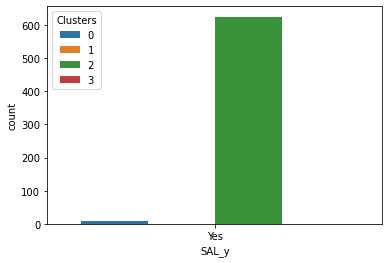

In [21]:
sns.countplot(df1[df1["SAL_y"]=='Yes'].SAL_y,hue=df1['Clusters'])

In [22]:
for cluster in df1.Clusters.unique():
    mean=(np.round(df1[df1.Clusters==cluster].Annual_recurring_revenue).sum(),0)
    print('Cluster:',cluster,'Annual_recurring_revenue:',mean)

Cluster: 3 Annual_recurring_revenue: (18880.0, 0)
Cluster: 1 Annual_recurring_revenue: (186152.0, 0)
Cluster: 0 Annual_recurring_revenue: (117157.0, 0)
Cluster: 2 Annual_recurring_revenue: (5524997.0, 0)


In [23]:
for cluster in df1.Clusters.unique():
    mean=(df1[df1.Clusters==cluster].Demo_Sat.replace(['Yes','0'],[1,0])).sum()
    print('Cluster:',cluster,'Demo:',mean)

Cluster: 3 Demo: 3
Cluster: 1 Demo: 8
Cluster: 0 Demo: 9
Cluster: 2 Demo: 381


In [24]:
print('Higly_Valuable: Cluster 2')
print('Least_Valuable: Cluster 3')

Higly_Valuable: Cluster 2
Least_Valuable: Cluster 3


C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



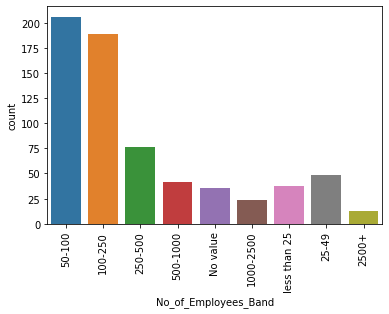

In [27]:
sns.countplot(df1[df1['Clusters']==2]['No_of_Employees_Band'])
plt.xticks(rotation=90)
plt.show()

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



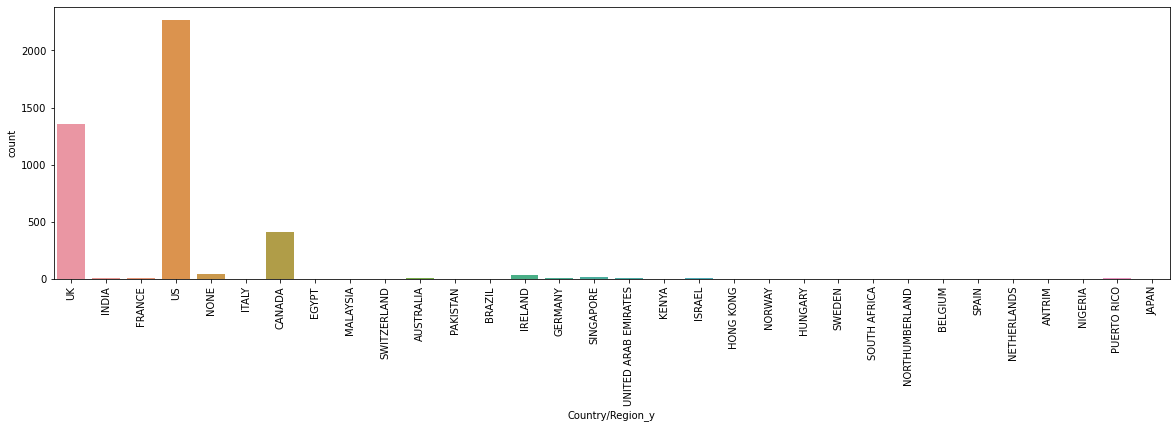

In [28]:
plt.figure(figsize=(20,5))
sns.countplot(df1[df1['Clusters']==3]['Country/Region_y'])
plt.xticks(rotation=90)
plt.show()

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



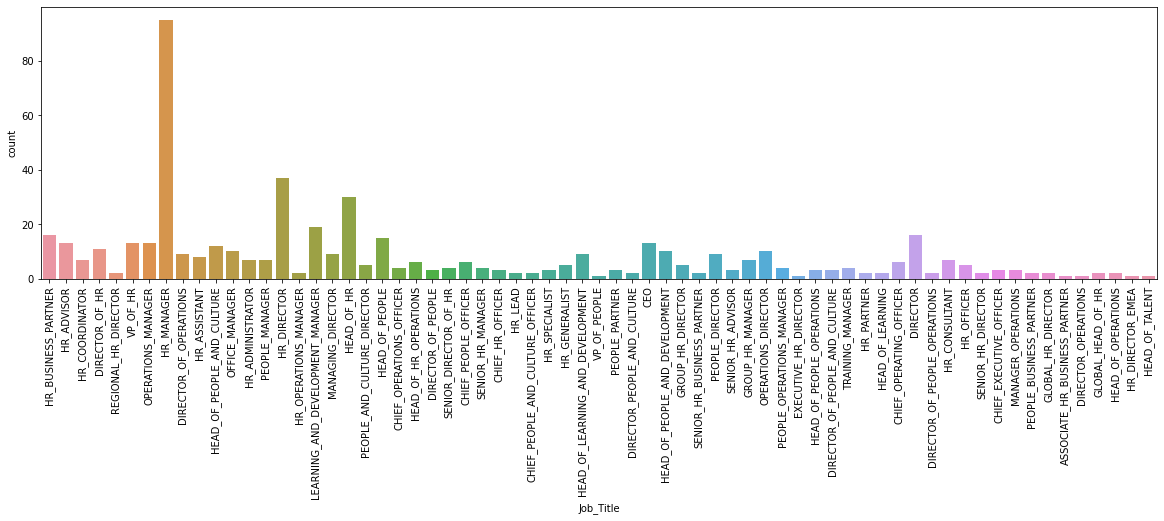

In [29]:
plt.figure(figsize=(20,5))
x=df1.copy()
x=x[x["Job_Title"]!='NONE']
x=x[x["Job_Title"]!='Other']
sns.countplot(x[x['Clusters']==2]["Job_Title"])
plt.xticks(rotation=90)
plt.show()

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



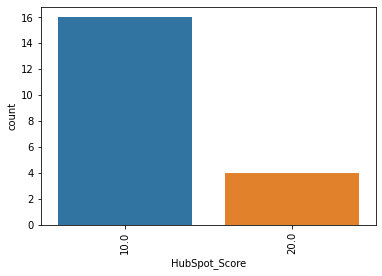

In [30]:
# plt.figure(figsize=(20,5))
x=df1.copy()
x=x[x["HubSpot_Score"]!=0]
sns.countplot(x[x['Clusters']==3]["HubSpot_Score"])
plt.xticks(rotation=90)
plt.show()

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



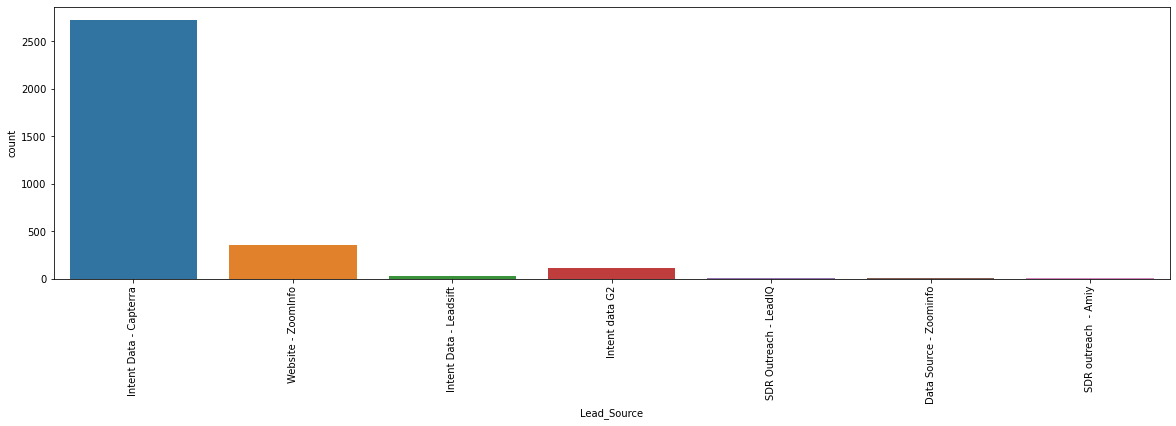

In [31]:
plt.figure(figsize=(20,5))
x=df1.copy()
x=x[x["Lead_Source"]!='None']
x=x[x["Lead_Source"]!='Other - Unknown']
sns.countplot(x[x['Clusters']==3]["Lead_Source"])
plt.xticks(rotation=90)
plt.show()

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



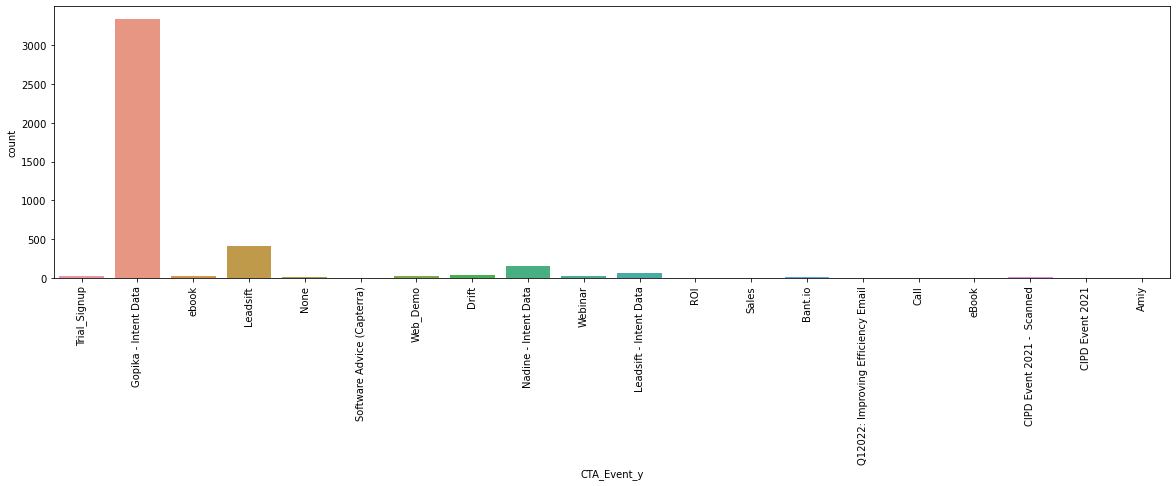

In [2639]:
plt.figure(figsize=(20,5))
sns.countplot(df1[df1['Clusters']==3]['CTA_Event_y'])
plt.xticks(rotation=90)
plt.show()

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



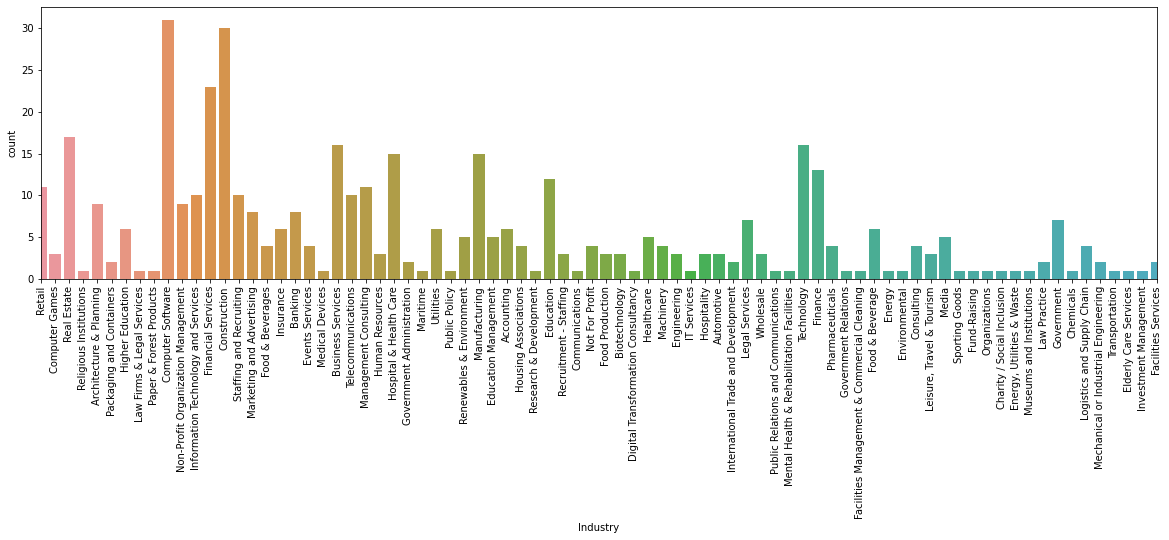

In [2640]:
x=df1.copy()
x=x[x["Industry"]!='None'] 
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x[x['Clusters']==2]["Industry"], ax=ax)  # distplot is deprecate and replaced by histplot
ax.set_xlim(1,80)
plt.xticks(rotation=90)
plt.show()

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



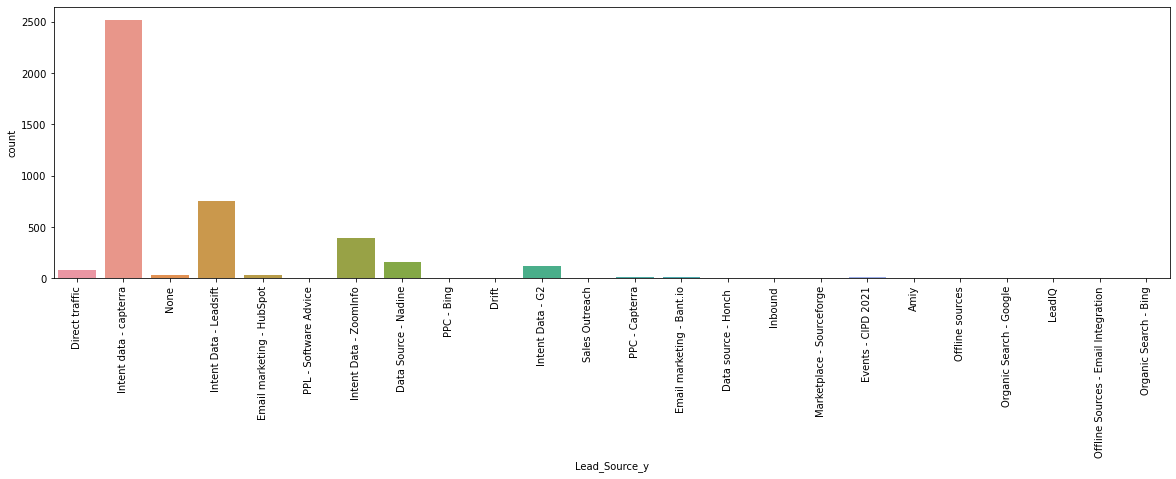

In [2641]:
plt.figure(figsize=(20,5))
sns.countplot(df1[df1['Clusters']==3]['Lead_Source_y'])
plt.xticks(rotation=90)
plt.show()

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Inbound/Outbound', ylabel='count'>

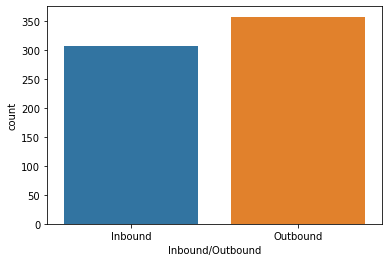

In [2597]:
sns.countplot(df1[df1['Clusters']==2]['Inbound/Outbound'])

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



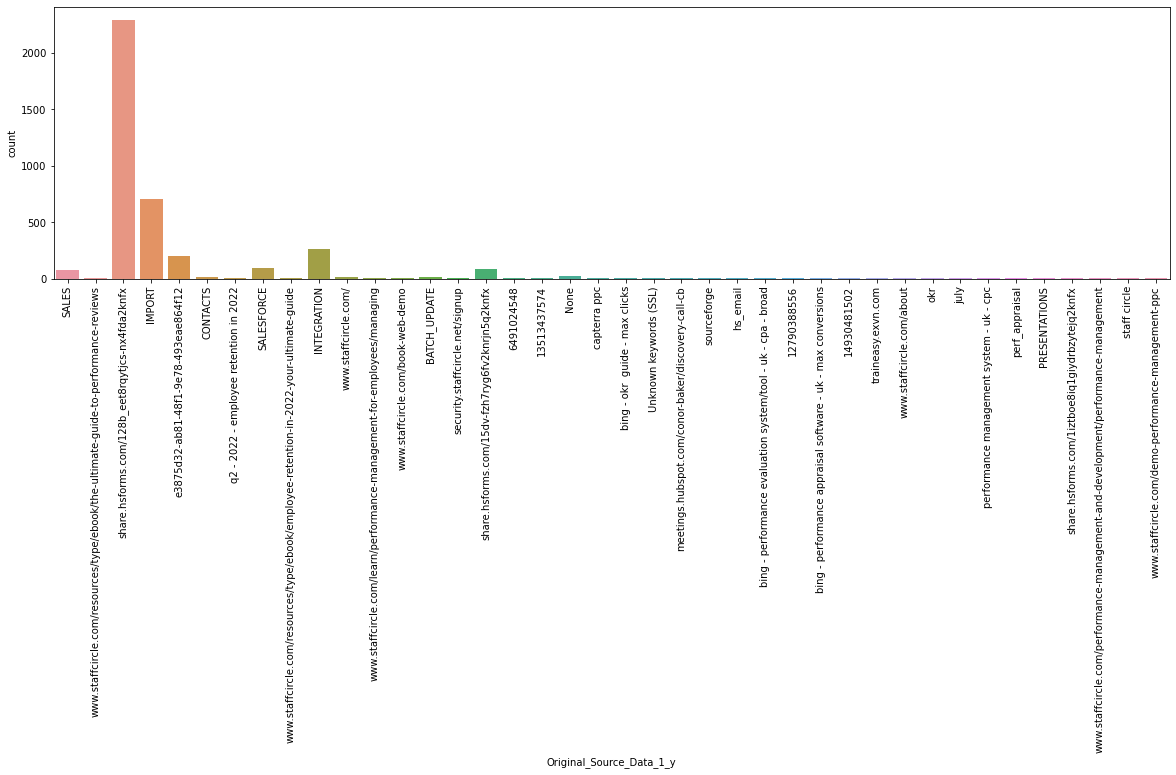

In [2607]:
x=df1.copy()
x=x[x["Industry"]!='None'] 
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x[x['Clusters']==3]["Original_Source_Data_1_y"], ax=ax)  # distplot is deprecate and replaced by histplot
# ax.set_xlim(1,50)
plt.xticks(rotation=90)
plt.show()

C:\Users\king_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



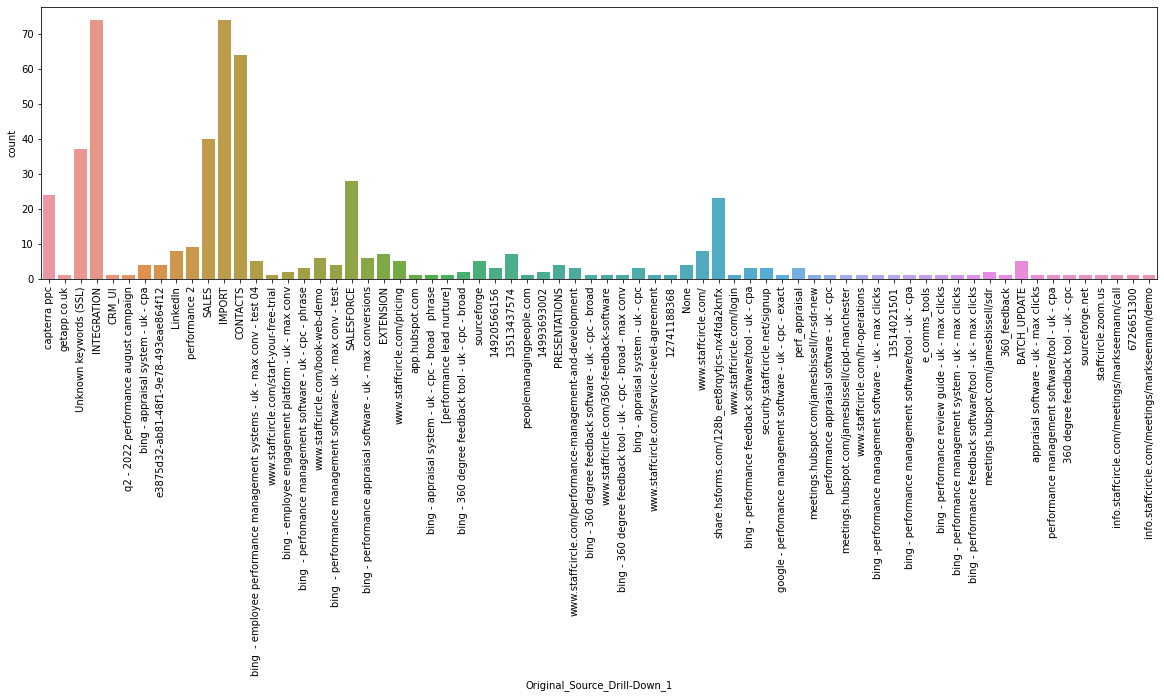

In [2609]:
x=df1.copy()
x=x[x["Industry"]!='None'] 
fig, ax = plt.subplots(figsize=(20,5))
sns.countplot(x[x['Clusters']==2]["Original_Source_Drill-Down_1"], ax=ax)  # distplot is deprecate and replaced by histplot
# ax.set_xlim(1,50)
plt.xticks(rotation=90)
plt.show()